# Lecture 1 - 31.05.2021 

# Example: Generation of a chirp signal, spectral analysis, and matched filter


A chirp is a signal in which the frequency increases with time following a quadtratic law of time. It can be expressed as:

$$y=\exp ( j\pi k t^2 ) \cdot \text{rect} \left(\frac{t}{T_c}\right) $$

where $t$ indicates time and $K$ is the chirp rate. The function $\text{rect}(\cdot)$ indicates a rectangular function ('box') which equals 1 for $-T_c/2 \leqslant t \leqslant T_c/2$. As a consequence, $T_c$ indicates the total duration of the signal.

The objective of this notebook is to generate a chirp signal with:
- duration $T_c = 500 \text{ ms}$ 
- chirp rate $K = 500 \text{ s}^{-2}$ 
- observation time $T_d = 2000 \text{ ms}$

and to calculate its Fourier spectrum. Afterwards, the matched filter is implemented, and applied to the generated chirp in the time and frequency domain.

## 1. Generation of the chirp signal

First of all, we import the necessary modules. Numpy will be enough for the calculations, together with some fft routines, and Matplotlib for plotting:

In [6]:
# --- import libraries

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, fftshift, ifft


For simplicity, we implement the $\text{rect}(\cdot)$ as a function:

In [5]:
# --- create useful functions

def rect(t, T0):
    # Implements y = rect(t/T0) = 1 if abs(t/T0) <= 0.5, 0 otherwise 
    # All input / outputs are Numpy arrays
    
    N = t.shape[0]
    y = np.zeros(N, 'float32') 
    y[np.abs(t/T0) <= 0.5] = 1
    
    return y


And now, the input parameters defined in the beginning:

In [66]:
# --- Input parameters

# number of samples 
Ns = 2001
# signal duration, s
Td = 2
# chirp duration, s
Tc = .5
# chirp rate
K = 500
# max duration for zoom plotting, s
Tzoom = .2


A couple of notes:

- Tzoom is defines a time interval around zero in which to zoom in for visualization purposes;

- the number of samples is not random value, but it should be set according to the Nyquist theorem. The (discrete) Fourier transform of a set of signal samples is periodic with period $1/T_s$. According to the Nyquist theorem, the reconstruction of a bandlimited signal is possible if the signal is sampled as twice faster as its largest frequency component. In our case, the largest frequency in the signal is at $K \cdot T_c /2= 125 \text{ Hz}$. As a consequence, $1/T_s > 250 \text{Hz}$, from which $T_s < 4 \text{ ms}$. It results that the minimum suitable number of samples in $T_d = 2 \text{ s}$ is 500. 



We can now generate the chirp signal:

In [67]:
# --- Generation of the chirp signal

# time axis
time = np.linspace(-Td/2, Td/2, Ns)
# generate chirp
chirp = rect(time, Tc) * np.exp(1j*np.pi*K*time**2)


We are ready to plot:

- the real part: $ R(t) = \cos(\pi K t^2 ) \cdot \text{rect} \left(\frac{t}{T_c}\right) $
- the imaginary part: $ I(t) = \sin(\pi K t^2 ) \cdot \text{rect} \left(\frac{t}{T_c}\right) $
- the amplitude : $ A(t) = \text{rect} \left(\frac{t}{T_c}\right) $
- the phase: $ P(t) = \pi K t^2 $

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 9 Text yticklabel objects>)

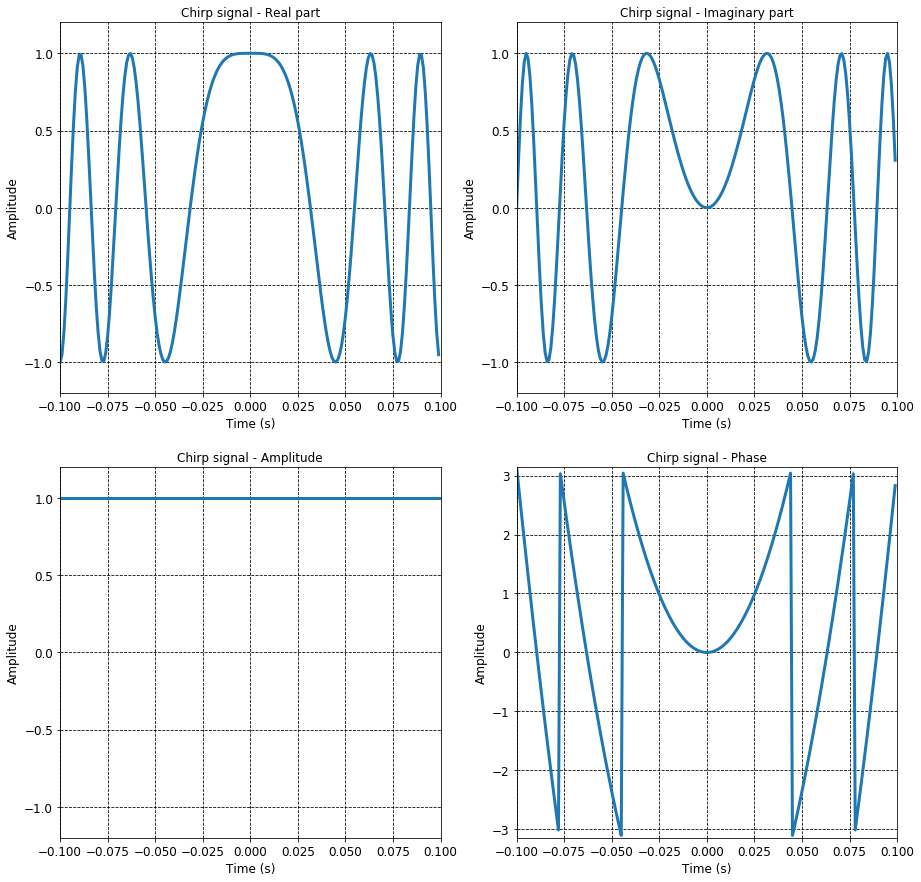

In [68]:
# --- plot chirp signal

# find indices for zoom
ii = np.where(np.abs(time) <= Tzoom/2)
imin = np.min(ii[0])
imax = np.max(ii[0])
if imax == Ns-1 : imax = Ns-2
  
plt.figure(figsize = (15,15))

# plot chirp - real part
plt.subplot(2, 2, 1)
plt.plot(time[imin:imax+1], np.real(chirp[imin:imax+1]), lw = 3)
plt.xlabel('Time (s)', fontsize = '12')
plt.ylabel('Amplitude', fontsize = '12')
plt.title('Chirp signal - Real part', fontsize = '12')
plt.axis([time[imin], time[imax+1], -1.2, 1.2])
plt.grid(True, linestyle = '--', color = 'k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plot chirp - imaginary part
plt.subplot(2, 2, 2)
plt.plot(time[imin:imax+1], np.imag(chirp[imin:imax+1]), lw = 3)
plt.xlabel('Time (s)', fontsize = '12')
plt.ylabel('Amplitude', fontsize = '12')
plt.title('Chirp signal - Imaginary part', fontsize = '12')
plt.axis([time[imin], time[imax+1], -1.2, 1.2])
plt.grid(True, linestyle = '--', color = 'k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plot chirp - amplitude
plt.subplot(2, 2, 3)
plt.plot(time[imin:imax+1], np.abs(chirp[imin:imax+1]), lw = 3)
plt.xlabel('Time (s)', fontsize = '12')
plt.ylabel('Amplitude', fontsize = '12')
plt.title('Chirp signal - Amplitude', fontsize = '12')
plt.axis([time[imin], time[imax+1], -1.2, 1.2])
plt.grid(True, linestyle = '--', color = 'k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plot chirp - phase part
plt.subplot(2, 2, 4)
plt.plot(time[imin:imax+1], rect(time[imin:imax+1], Tc) * np.angle(chirp[imin:imax+1]), lw = 3)
plt.xlabel('Time (s)', fontsize = '12')
plt.ylabel('Amplitude', fontsize = '12')
plt.title('Chirp signal - Phase', fontsize = '12')
plt.axis([time[imin], time[imax+1], -np.pi, np.pi])
plt.grid(True, linestyle = '--', color = 'k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


## 2. Spectrum of the chirp signal

The spectrum of the chirp signal generated above is simply calculated by using the function fft(.), which implements the (discrete) Fourier transform. fft(.) provides the spectrum in the interval $[0, 1/T_s]$. However, the spectrum is tipically visualized between $[-1/(2T_s), 1/(2T_s)]$. Remembering that the spectrum is periodic, one can just 'shift' the visulaization window, that is implemented by means of the function fftshift(.).

The chirp spectrum is calculated here below:

In [69]:
# --- Calculate chirp spectrum

# derive time sampling
Ts = time[1] - time[0]

# make frequency axis ... scaled in Hz
frequency = fftshift(fftfreq(Ns)) / Ts

# calculate chirp spectrum
chirp_spectrum = fftshift(fft(chirp))

And we are ready to plot it:

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 8 Text yticklabel objects>)

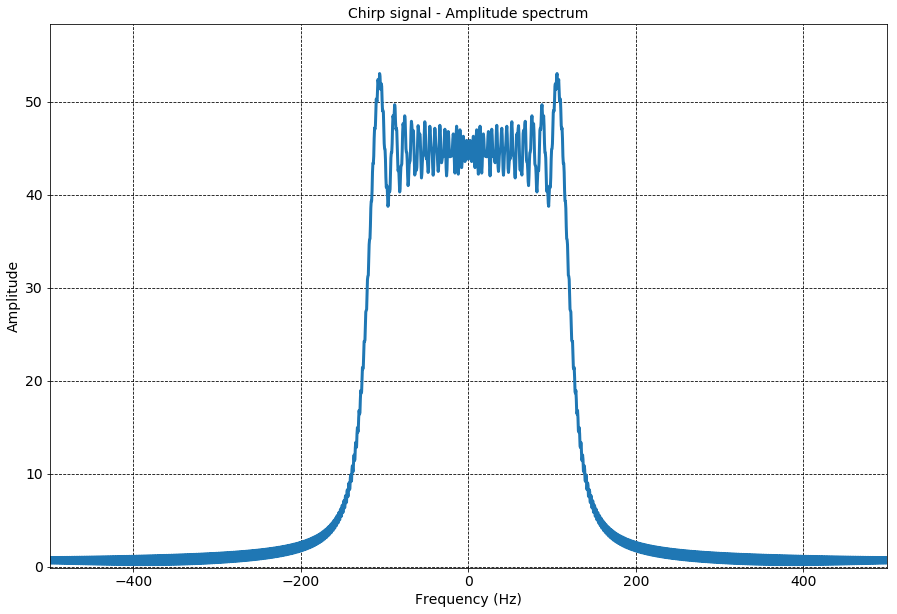

In [70]:
# --- plot chirp spectrum

plt.figure(figsize = (15,10))
plt.plot(frequency, np.abs(chirp_spectrum), lw = 3)
plt.xlabel('Frequency (Hz)', fontsize = '14')
plt.ylabel('Amplitude', fontsize = '14')
plt.title('Chirp signal - Amplitude spectrum', fontsize = '14')
plt.axis([np.min(frequency), np.max(frequency), -.1, 1.1*np.max(np.abs(chirp_spectrum))])
plt.grid(True, linestyle = '--', color = 'k')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


The chirp spectrum looks like a rectangular function. We can now measure the bandwidth, and verify if it matches the theoretical expectation.

But we now have the tool to answer to the following questions:
- ... what happens if $T_s$ increased for the same $T_d$?
- ... what happens if $T_d$ increases for the same $T_s$?


## 3. Matched filter

The response of the matched filter in the time domain is a complex conjugate, time-reversed version of the signal to which the filter is adapted.  

It can be generated quite simply- both operations can be well recognized:

In [71]:
# --- Create matched filter response

matfilter = np.conj(chirp[::-1])


A filtering of a signal can be implemented in the freqeuncy domain (normally preferred for computational reasons). But one has to be careful that non-nul spectral domain are multiplied! In other words, all the shifts of the independent variables have to be taken care of ... also when transforming back from the frequency domain. 

In [72]:
# --- OPTION 1: filter in the frequency domain

# get spectrum of matched filter response
matfilter_spectrum = fftshift(fft(matfilter))
# get spectrum of output
matfilter_output_spectrum = chirp_spectrum * matfilter_spectrum
# back in the time domain
matfilter_output = fftshift(ifft(fftshift(matfilter_output_spectrum, -1)))


Alternatively, a filtering can be implemented also in the time domain by means of a convolution operation:

In [73]:
# --- OPTION 2: filter in the time domain

matfilter_output_conv = np.convolve(chirp, matfilter, mode = 'same')


The results of both operations can finally be plotted:

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

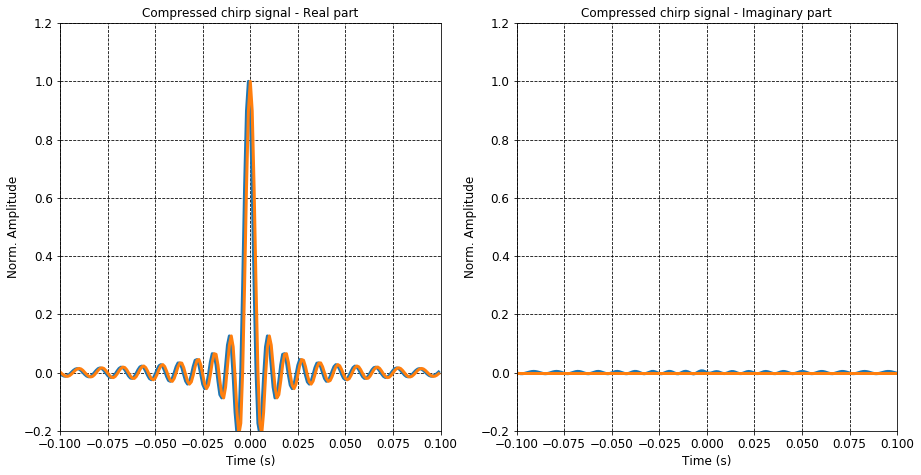

In [74]:
# --- Plot results
plt.figure(figsize = (15, 7.5))

plt.subplot(1,2,1)
plt.plot(time[imin:imax+1], np.real(matfilter_output[imin:imax+1])/np.max(np.abs(matfilter_output)), lw = 3)
plt.plot(time[imin:imax+1], np.real(matfilter_output_conv[imin:imax+1])/np.max(np.abs(matfilter_output_conv)), lw = 3)
plt.xlabel('Time (s)', fontsize = '12')
plt.ylabel('Norm. Amplitude', fontsize = '12')
plt.title('Compressed chirp signal - Real part', fontsize = '12')
plt.axis([time[imin], time[imax+1], -.2, 1.2])
plt.grid(True, linestyle = '--', color = 'k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1,2,2)
plt.plot(time[imin:imax+1], np.imag(matfilter_output[imin:imax+1])/np.max(np.abs(matfilter_output)), lw = 3)
plt.plot(time[imin:imax+1], np.imag(matfilter_output_conv[imin:imax+1])/np.max(np.abs(matfilter_output_conv)), lw = 3)
plt.xlabel('Time (s)', fontsize = '12')
plt.ylabel('Norm. Amplitude', fontsize = '12')
plt.title('Compressed chirp signal - Imaginary part', fontsize = '12')
plt.axis([time[imin], time[imax+1], -.2, 1.2])
plt.grid(True, linestyle = '--', color = 'k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

